In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
#Dataset
downloaded = drive.CreateFile({'id':"12f9gd7u5hGDwWEZgOd-O9iMkM6lE9vF-"})   # replace the id with id of file you want to access
downloaded.GetContentFile('stock_prices_sample.csv')        # replace the file name with your file

In [ ]:
df=pd.read_csv('stock_prices_sample.csv')

In [ ]:
def get_year(date):
  year=date.split('-')[0]
  return year

In [ ]:
df['Year']=df['DATE'].apply(get_year)

In [ ]:
df = df[df['Year'] != '2013']

In [ ]:
data=df[ ['DATE', 'OPEN']]

# Preprocessing Dataset

In [ ]:
from datetime import date
from fastai.tabular import add_datepart
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

In [ ]:
add_datepart(data, 'DATE', drop=False)
data.drop('DATEElapsed', axis=1, inplace=True)  # don't need this

/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [ ]:
#Reverse Order of Data
data=data.iloc[::-1]

In [ ]:
data

,DATE,OPEN,DATEYear,DATEMonth,DATEWeek,DATEDay,DATEDayofweek,DATEDayofyear,DATEIs_month_end,DATEIs_month_start,DATEIs_quarter_end,DATEIs_quarter_start,DATEIs_year_end,DATEIs_year_start
998,2014-06-23,19.05,2014,6,26,23,0,174,False,False,False,False,False,False
997,2014-06-24,18.91,2014,6,26,24,1,175,False,False,False,False,False,False
996,2014-06-25,18.66,2014,6,26,25,2,176,False,False,False,False,False,False
995,2014-06-26,18.52,2014,6,26,26,3,177,False,False,False,False,False,False
994,2014-06-27,18.63,2014,6,26,27,4,178,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-05-30,18.47,2018,5,22,30,2,150,False,False,False,False,False,False
6,2018-05-31,18.52,2018,5,22,31,3,151,True,False,False,False,False,False
5,2018-06-01,18.58,2018,6,22,1,4,152,False,True,False,False,False,False
4,2018-06-04,18.86,2018,6,23,4,0,155,False,False,False,False,False,False


In [ ]:
data.loc[:, 'DATEYear'] = LabelEncoder().fit_transform(data['DATEYear'])

## Add Lag Features

In [ ]:
N=15

In [ ]:
col_name='OPEN'

In [ ]:
def add_lags(data, col_name, num):
  index=np.array([i for i in range (data.shape[0])])
  shift_list=index+1
  shift_list=shift_list[:N]
  for num in shift_list:
    train_shift=data[col_name].shift(periods=num)
    name='{}_lag_{}'.format(col_name, num)
    data[name]=train_shift
  return data


In [ ]:
data=add_lags(data, col_name, N)

In [ ]:
data

,DATE,OPEN,DATEYear,DATEMonth,DATEWeek,DATEDay,DATEDayofweek,DATEDayofyear,DATEIs_month_end,DATEIs_month_start,DATEIs_quarter_end,DATEIs_quarter_start,DATEIs_year_end,DATEIs_year_start,OPEN_lag_1,OPEN_lag_2,OPEN_lag_3,OPEN_lag_4,OPEN_lag_5,OPEN_lag_6,OPEN_lag_7,OPEN_lag_8,OPEN_lag_9,OPEN_lag_10,OPEN_lag_11,OPEN_lag_12,OPEN_lag_13,OPEN_lag_14,OPEN_lag_15
998,2014-06-23,19.05,0,6,26,23,0,174,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,2014-06-24,18.91,0,6,26,24,1,175,False,False,False,False,False,False,19.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,2014-06-25,18.66,0,6,26,25,2,176,False,False,False,False,False,False,18.91,19.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,2014-06-26,18.52,0,6,26,26,3,177,False,False,False,False,False,False,18.66,18.91,19.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994,2014-06-27,18.63,0,6,26,27,4,178,False,False,False,False,False,False,18.52,18.66,18.91,19.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-05-30,18.47,4,5,22,30,2,150,False,False,False,False,False,False,18.51,18.76,18.78,18.83,19.26,19.31,19.14,19.72,19.50,19.50,19.73,19.79,19.66,19.55,19.39
6,2018-05-31,18.52,4,5,22,31,3,151,True,False,False,False,False,False,18.47,18.51,18.76,18.78,18.83,19.26,19.31,19.14,19.72,19.50,19.50,19.73,19.79,19.66,19.55
5,2018-06-01,18.58,4,6,22,1,4,152,False,True,False,False,False,False,18.52,18.47,18.51,18.76,18.78,18.83,19.26,19.31,19.14,19.72,19.50,19.50,19.73,19.79,19.66
4,2018-06-04,18.86,4,6,23,4,0,155,False,False,False,False,False,False,18.58,18.52,18.47,18.51,18.76,18.78,18.83,19.26,19.31,19.14,19.72,19.50,19.50,19.73,19.79


### Correlation

In [ ]:
corr_matrix = data.corr()
corr_matrix["OPEN"].sort_values(ascending=False)

OPEN                    1.000000
OPEN_lag_1              0.995242
OPEN_lag_2              0.991011
OPEN_lag_3              0.986718
OPEN_lag_4              0.982074
OPEN_lag_5              0.977543
OPEN_lag_6              0.973308
OPEN_lag_7              0.969136
OPEN_lag_8              0.965540
OPEN_lag_9              0.961490
OPEN_lag_10             0.957576
OPEN_lag_11             0.953612
OPEN_lag_12             0.949433
OPEN_lag_13             0.945561
OPEN_lag_14             0.941409
OPEN_lag_15             0.937183
DATEYear                0.322445
DATEWeek                0.100380
DATEMonth               0.088851
DATEDayofyear           0.086562
DATEDay                 0.006901
DATEIs_month_start      0.004975
DATEIs_month_end       -0.001618
DATEDayofweek          -0.003524
DATEIs_quarter_start   -0.021711
DATEIs_year_end        -0.032461
DATEIs_quarter_end     -0.038951
DATEIs_year_start            NaN
Name: OPEN, dtype: float64

In [ ]:
N_final=7

In [ ]:

for i in range(N_final+1, N+1, 1):
  name='OPEN_lag_{}'.format(i)
  data.drop([name], axis=1, inplace=True)

# Normalisation

In [ ]:
#rolling can work on panda series
def moving_avg_stddev(df, col, N):
  mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
  std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
  mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
  std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

  df[col+'_mean'] = mean_list
  df[col+'_std'] = std_list

  return df

In [ ]:
data=moving_avg_stddev(data, 'OPEN', N_final)

In [ ]:
def scaling(data, col_name, N):
  df=data.copy()
  scaled='{}_scaled'.format(col_name)
  mean='{}_mean'.format(col_name)
  stddev='{}_std'.format(col_name)
  df[scaled] = (df[col_name] - df[mean]) / df[stddev]
  for i in range(1, N+1):
    name='{}_lag_{}'.format(col_name, i)
    scaled_name='{}_lag_scaled_{}'.format(col_name, i)
    df[scaled_name]=(df[name]-df[mean]) / df[stddev]
    df.drop(name, axis=1, inplace=True)
  return df

In [ ]:
data

,DATE,OPEN,DATEYear,DATEMonth,DATEWeek,DATEDay,DATEDayofweek,DATEDayofyear,DATEIs_month_end,DATEIs_month_start,DATEIs_quarter_end,DATEIs_quarter_start,DATEIs_year_end,DATEIs_year_start,OPEN_lag_1,OPEN_lag_2,OPEN_lag_3,OPEN_lag_4,OPEN_lag_5,OPEN_lag_6,OPEN_lag_7,OPEN_mean,OPEN_std
998,2014-06-23,19.05,0,6,26,23,0,174,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,2014-06-24,18.91,0,6,26,24,1,175,False,False,False,False,False,False,19.05,NaN,NaN,NaN,NaN,NaN,NaN,19.050000,NaN
996,2014-06-25,18.66,0,6,26,25,2,176,False,False,False,False,False,False,18.91,19.05,NaN,NaN,NaN,NaN,NaN,18.980000,0.098995
995,2014-06-26,18.52,0,6,26,26,3,177,False,False,False,False,False,False,18.66,18.91,19.05,NaN,NaN,NaN,NaN,18.873333,0.197569
994,2014-06-27,18.63,0,6,26,27,4,178,False,False,False,False,False,False,18.52,18.66,18.91,19.05,NaN,NaN,NaN,18.785000,0.239235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-05-30,18.47,4,5,22,30,2,150,False,False,False,False,False,False,18.51,18.76,18.78,18.83,19.26,19.31,19.14,18.941429,0.298408
6,2018-05-31,18.52,4,5,22,31,3,151,True,False,False,False,False,False,18.47,18.51,18.76,18.78,18.83,19.26,19.31,18.845714,0.329892
5,2018-06-01,18.58,4,6,22,1,4,152,False,True,False,False,False,False,18.52,18.47,18.51,18.76,18.78,18.83,19.26,18.732857,0.275180
4,2018-06-04,18.86,4,6,23,4,0,155,False,False,False,False,False,False,18.58,18.52,18.47,18.51,18.76,18.78,18.83,18.635714,0.149316


In [ ]:
scaled_data=scaling(data, 'OPEN', N_final)

In [ ]:
scaled_data

,DATE,OPEN,DATEYear,DATEMonth,DATEWeek,DATEDay,DATEDayofweek,DATEDayofyear,DATEIs_month_end,DATEIs_month_start,DATEIs_quarter_end,DATEIs_quarter_start,DATEIs_year_end,DATEIs_year_start,OPEN_mean,OPEN_std,OPEN_scaled,OPEN_lag_scaled_1,OPEN_lag_scaled_2,OPEN_lag_scaled_3,OPEN_lag_scaled_4,OPEN_lag_scaled_5,OPEN_lag_scaled_6,OPEN_lag_scaled_7
998,2014-06-23,19.05,0,6,26,23,0,174,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,2014-06-24,18.91,0,6,26,24,1,175,False,False,False,False,False,False,19.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,2014-06-25,18.66,0,6,26,25,2,176,False,False,False,False,False,False,18.980000,0.098995,-3.232488,-0.707107,0.707107,NaN,NaN,NaN,NaN,NaN
995,2014-06-26,18.52,0,6,26,26,3,177,False,False,False,False,False,False,18.873333,0.197569,-1.788409,-1.079794,0.185590,0.894204,NaN,NaN,NaN,NaN
994,2014-06-27,18.63,0,6,26,27,4,178,False,False,False,False,False,False,18.785000,0.239235,-0.647899,-1.107698,-0.522499,0.522499,1.107698,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-05-30,18.47,4,5,22,30,2,150,False,False,False,False,False,False,18.941429,0.298408,-1.579810,-1.445765,-0.607987,-0.540965,-0.373410,1.067568,1.235124,0.665435
6,2018-05-31,18.52,4,5,22,31,3,151,True,False,False,False,False,False,18.845714,0.329892,-0.987337,-1.138902,-1.017650,-0.259825,-0.199200,-0.047635,1.255823,1.407388
5,2018-06-01,18.58,4,6,22,1,4,152,False,True,False,False,False,False,18.732857,0.275180,-0.555481,-0.773521,-0.955220,-0.809861,0.098637,0.171317,0.353016,1.915632
4,2018-06-04,18.86,4,6,23,4,0,155,False,False,False,False,False,False,18.635714,0.149316,1.502089,-0.373130,-0.774963,-1.109823,-0.841935,0.832368,0.966312,1.301172


# Correlation with Categorical Variables

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


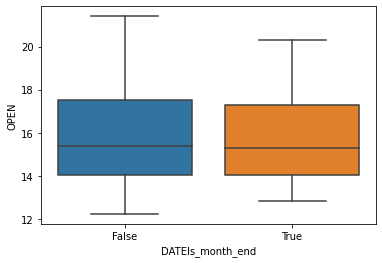

In [ ]:
sns.boxplot(scaled_data['DATEIs_month_end'], scaled_data['OPEN'])

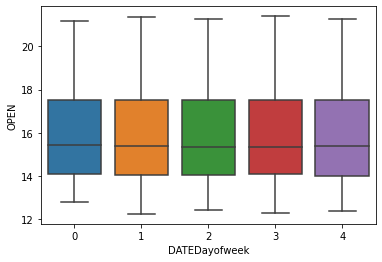

In [ ]:
sns.boxplot(scaled_data['DATEDayofweek'], scaled_data['OPEN'])

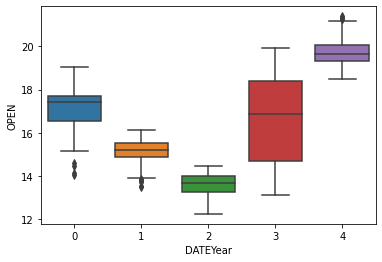

In [ ]:
sns.boxplot(scaled_data['DATEYear'], scaled_data['OPEN'])

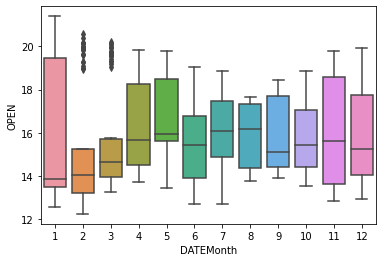

In [ ]:
sns.boxplot(scaled_data['DATEMonth'], scaled_data['OPEN'])

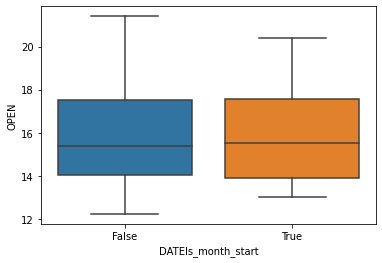

In [ ]:
sns.boxplot(scaled_data['DATEIs_month_start'], scaled_data['OPEN'])

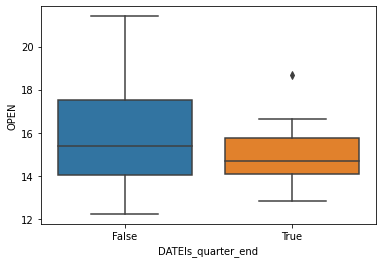

In [ ]:
sns.boxplot(scaled_data['DATEIs_quarter_end'], scaled_data['OPEN'])

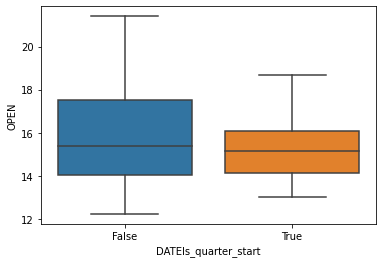

In [ ]:
sns.boxplot(scaled_data['DATEIs_quarter_start'], scaled_data['OPEN'])

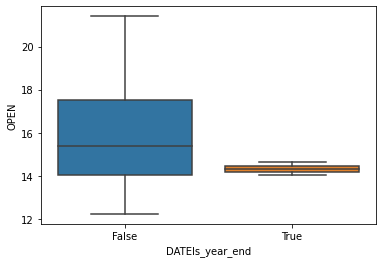

In [ ]:
sns.boxplot(scaled_data['DATEIs_year_end'], scaled_data['OPEN'])

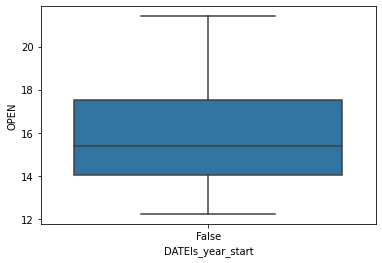

In [ ]:
sns.boxplot(scaled_data['DATEIs_year_start'], scaled_data['OPEN'])

# Determining Training and Validation Set

In [ ]:
features=['DATEYear', 'DATEMonth', 'DATEWeek', 'DATEDay', 'DATEIs_year_end','DATEDayofyear', 'DATEDayofweek']
features_lag=features.copy()
for i in range(1, N_final+1):
  name='OPEN_lag_scaled_{}'.format(i)
  features_lag.append(name)

In [ ]:
training_data=scaled_data.drop(['DATEIs_year_start', 'DATEIs_quarter_start', 'DATEIs_quarter_end','DATEIs_month_start', 'DATEIs_month_end' ], axis=1)

In [ ]:
training_data

,DATE,OPEN,DATEYear,DATEMonth,DATEWeek,DATEDay,DATEDayofweek,DATEDayofyear,DATEIs_year_end,OPEN_mean,OPEN_std,OPEN_scaled,OPEN_lag_scaled_1,OPEN_lag_scaled_2,OPEN_lag_scaled_3,OPEN_lag_scaled_4,OPEN_lag_scaled_5,OPEN_lag_scaled_6,OPEN_lag_scaled_7
998,2014-06-23,19.05,0,6,26,23,0,174,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,2014-06-24,18.91,0,6,26,24,1,175,False,19.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,2014-06-25,18.66,0,6,26,25,2,176,False,18.980000,0.098995,-3.232488,-0.707107,0.707107,NaN,NaN,NaN,NaN,NaN
995,2014-06-26,18.52,0,6,26,26,3,177,False,18.873333,0.197569,-1.788409,-1.079794,0.185590,0.894204,NaN,NaN,NaN,NaN
994,2014-06-27,18.63,0,6,26,27,4,178,False,18.785000,0.239235,-0.647899,-1.107698,-0.522499,0.522499,1.107698,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-05-30,18.47,4,5,22,30,2,150,False,18.941429,0.298408,-1.579810,-1.445765,-0.607987,-0.540965,-0.373410,1.067568,1.235124,0.665435
6,2018-05-31,18.52,4,5,22,31,3,151,False,18.845714,0.329892,-0.987337,-1.138902,-1.017650,-0.259825,-0.199200,-0.047635,1.255823,1.407388
5,2018-06-01,18.58,4,6,22,1,4,152,False,18.732857,0.275180,-0.555481,-0.773521,-0.955220,-0.809861,0.098637,0.171317,0.353016,1.915632
4,2018-06-04,18.86,4,6,23,4,0,155,False,18.635714,0.149316,1.502089,-0.373130,-0.774963,-1.109823,-0.841935,0.832368,0.966312,1.301172


In [ ]:
training_data.shape

(996, 19)

In [ ]:
train_size=800

In [ ]:
train=training_data[0:train_size]
validation=training_data[train_size:-14]
test=training_data[-14:]

In [ ]:
train.shape, validation.shape, test.shape

((800, 19), (182, 19), (14, 19))

In [ ]:
train_val=training_data[:-14]

In [ ]:
horizon=14

In [ ]:
train_val.shape

(982, 19)

In [ ]:
i

7

In [ ]:
test=train_val[i+train_size:i+train_size+horizon]

In [ ]:
test

,DATE,OPEN,DATEYear,DATEMonth,DATEWeek,DATEDay,DATEDayofweek,DATEDayofyear,DATEIs_year_end,OPEN_mean,OPEN_std,OPEN_scaled,OPEN_lag_scaled_1,OPEN_lag_scaled_2,OPEN_lag_scaled_3,OPEN_lag_scaled_4,OPEN_lag_scaled_5,OPEN_lag_scaled_6,OPEN_lag_scaled_7
191,2017-09-05,17.70,3,9,36,5,1,248,False,17.429543,0.100751,2.684407,0.897827,-1.285770,-0.590989,-1.186516,0.401555,0.699318,1.064575
190,2017-09-06,17.70,3,9,36,6,2,249,False,17.452857,0.140679,1.756790,1.756790,0.477278,-1.086570,-0.588982,-1.015486,0.121858,0.335110
189,2017-09-07,17.86,3,9,36,7,3,250,False,17.481429,0.169256,2.236679,1.291365,1.291365,0.227888,-1.071918,-0.658343,-1.012836,-0.067522
188,2017-09-08,17.80,3,9,36,8,4,251,False,17.537143,0.221112,1.188797,1.460153,0.736537,0.736537,-0.077530,-1.072502,-0.755920,-1.027276
187,2017-09-11,18.01,3,9,37,11,0,254,False,17.607143,0.214687,1.876487,0.898318,1.177795,0.432524,0.432524,-0.405907,-1.430655,-1.104599
186,2017-09-12,18.06,3,9,37,12,1,255,False,17.698571,0.232410,1.555135,1.339998,0.436421,0.694586,0.006147,0.006147,-0.768347,-1.714952
185,2017-09-13,17.98,3,9,37,13,2,256,False,17.807143,0.188566,0.916693,1.340948,1.075788,-0.037880,0.280311,-0.568198,-0.568198,-1.522771
184,2017-09-14,17.86,3,9,37,14,3,257,False,17.872857,0.147503,-0.087165,0.726377,1.268739,0.929763,-0.493937,-0.087165,-1.171889,-1.171889
183,2017-09-15,18.04,3,9,37,15,4,258,False,17.895714,0.127261,1.133782,-0.280639,0.662308,1.290940,0.898045,-0.752113,-0.280639,-1.537903
182,2017-09-18,18.15,3,9,38,18,0,261,False,17.944286,0.102609,2.004840,0.932808,-0.821428,0.348063,1.127723,0.640435,-1.406173,-0.821428


# Evaluating Parameters

In [ ]:
def get_mae(A, B):
  A=np.array(A)
  B=np.array(B)
  diff=A-B
  diff=np.abs(diff)
  return np.mean(diff)

In [ ]:
def get_rmse(A,B):
  A=np.array(A)
  B=np.array(B)
  diff=A-B
  square=diff**2
  return np.sqrt(np.mean(square))

In [ ]:
def get_mape(actual, estimate):
  actual=np.array(actual)
  estimate=np.array(estimate)
  diff=(actual-estimate)/actual
  diff=np.abs(diff)
  return np.mean(diff)*100

In [ ]:
train_val.shape[0]

982

In [ ]:
horizon

14

In [ ]:
val_size=validation.shape[0]

In [ ]:
for i in range(0, val_size-horizon+1, int(horizon/2)):
  print(i)

0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168


# Train Model

In [ ]:
def train_model(train_val, train_size, H, N_final, features, features_lag, n_estimators, max_depth, val_size):
  
  predictions=[]
  rmse_net=[]
  mape_net=[]
  mae_net=[]
  #df=train_val.shape[0]
  for i in range(0, val_size-H+1, int(H/2)):
    train=train_val[i:train_size+i].copy()
    test=train_val[i+train_size:i+train_size+H].copy()
  # for i in range(train_size, df-H+1, int(H/2)):
  #       # Split into train and test
  #   train = train_val[i-train_size:i].copy()
  #   test = train_val[i:i+H].copy()

    train.dropna(axis=0, inplace=True)
    
    trainX=train[features_lag]
    trainY=train['OPEN_scaled']

    testX=test[features]
    testY=test['OPEN']

    prev_values=train[-N_final:]['OPEN'].to_numpy()
    prev_mean=test.iloc[0]['OPEN_mean']
    prev_stddev=test.iloc[0]['OPEN_std']

    rmse, mape, mae, prediction, features_importance =fit_model(i, trainX, trainY, testX, testY, prev_values, prev_mean, prev_stddev, n_estimators, max_depth, H, N_final)

    rmse_net.append(rmse)
    mape_net.append(mape)
    mae_net.append(mae)
    predictions.append(prediction)

  return predictions, mape_net, mae_net, rmse_net, features_importance 

In [ ]:
def fit_model (i, trainX, trainY, testX, testY, prev_values, prev_stddev, prev_mean, n_estimators, max_depth, H, N):

      model = XGBRegressor(objective ='reg:squarederror',
                         seed=55,
                         n_estimators=n_estimators,
                         max_depth=max_depth)
      
      model.fit(trainX, trainY)

      prediction=predict_N(model, testX, prev_values, prev_stddev, prev_mean, H, N_final)

      if i==63:
        print (prediction)
        print (testY)

      rmse = get_rmse(testY, prediction)
      mape = get_mape(testY, prediction)
      mae = get_mae(testY, prediction)

      imp_features = model.feature_importances_
      
      return rmse, mape, mae, prediction, imp_features

In [ ]:
def predict_N(model, testX, prev_values, prev_stddev, prev_mean, H, N_final):

  forecast=prev_values.copy()

  for i in range(H):
    forecast_scaled = (forecast[-N_final:]-prev_mean)/prev_stddev
    # print(forecast_scaled)
    # X=testX.iloc[i, :]
    X=testX[i:i+1].copy()
    for j in range(1, N_final+1): #working
      name='OPEN_lag_scaled_{}'.format(j)
      X[name]=forecast_scaled[-j]
    # print (X)
    # for n in range(N_final,0,-1):
    #   X.loc[:, "OPEN_lag_scaled_"+str(n)] = forecast_scaled[-n]

    Y=model.predict(X)
    rescaled=(Y* prev_stddev) + prev_mean
    forecast=np.concatenate((forecast, rescaled))

    prev_mean=np.mean(forecast[-N_final:])
    prev_stddev=np.std(forecast[-N_final:])

  return forecast[-H:]

In [ ]:
n_estimators = 500
max_depth = 10

In [ ]:
np.mean(mape_net)

39.036452990115016

In [ ]:
predictions, mape_net, mae_net, rmse_net, features_importance = train_model(train_val, train_size, horizon, N_final, features, features_lag, n_estimators, max_depth, validation.shape[0])

[ 7.388726 12.923316 15.869455 18.003086 19.304819 21.456657 22.81049  20.447897 21.132004 21.388296 22.294666
 21.980515 22.135822 22.096367]
135    19.3600
134    19.2900
133    19.5500
132    19.5952
131    19.7600
130    19.7700
129    19.7000
128    19.7800
127    19.7300
126    19.4000
125    19.3540
124    19.4141
123    19.4900
122    19.6900
Name: OPEN, dtype: float64


In [ ]:
predictions, mape_net, mae_net, rmse_net, features_importance = train_model(train_val, train_size, horizon, N_final, features, features_lag, n_estimators, max_depth, validation.shape[0])

[ 6.74045  12.315695 15.012709 17.313782 18.406067 17.972456 21.062317 16.537508 18.384108 18.434263 19.968239
 20.000885 20.348656 21.357744]
135    19.3600
134    19.2900
133    19.5500
132    19.5952
131    19.7600
130    19.7700
129    19.7000
128    19.7800
127    19.7300
126    19.4000
125    19.3540
124    19.4141
123    19.4900
122    19.6900
Name: OPEN, dtype: float64


In [ ]:
mape_net

[89.86193375402064,
 47.835327668573605,
 43.34754075044285,
 102.0795502990429,
 29.656799012139007,
 13.010416763805194,
 49.908158339322746,
 34.308736599675086,
 7.577806508891396,
 14.736692017178651,
 58.22283887357135,
 1.459664146239422,
 29.903780139240656,
 92.51743432570102,
 5.505757826079189,
 11.721049921019159,
 36.57408765140303,
 103.43280512264386,
 11.185640029041,
 18.567106885850905,
 24.955746835308993,
 5.058248610039082,
 22.76967384275329,
 49.680387265107164,
 11.727848122066515]

In [ ]:
mape_net

[10.637050591779728,
 2.292492488158364,
 4.853209037232255,
 31.31440420172389,
 13.37970425250871,
 3.2894532181571305,
 20.08846909093016,
 18.370744406764945,
 5.00666673693499,
 563.6296510769542,
 16.615636385641302,
 6.571516419664049,
 39.60141479666785,
 17.751332059761317,
 8.194873526538201,
 63.364956942048536,
 20.00091824803672,
 30.480681259672792,
 58.404021836258316,
 26.483833081261615,
 26.08159702497062,
 11.812885897382804,
 7.514427746073972,
 12.679175101218929,
 4.0218407233147495]

In [ ]:
mae_net

[1.8815994042532782,
 0.41454227447509745,
 0.8858365576607837,
 5.77693389478411,
 2.4861650822230743,
 0.6126074746268133,
 3.7921129395621156,
 3.468642960248675,
 0.9496702721732001,
 110.23553308890207,
 3.2623086857387,
 1.2864449833461218,
 7.795737922123501,
 3.7104449326651436,
 1.7080066244942809,
 12.62064161703927,
 3.925847692435128,
 6.0178112738473075,
 11.571483065795897,
 5.242634357779366,
 5.075108157566616,
 2.2892603737967354,
 1.4633296524047854,
 2.4675845929827007,
 0.7803335189819338]

In [ ]:
rmse_net

9.349902017071585

In [ ]:
len(predictions)

25

In [ ]:
validation['OPEN'][0:14]

198    17.5368
197    17.5000
196    17.4700
195    17.3100
194    17.3700
193    17.3000
192    17.5200
191    17.7000
190    17.7000
189    17.8600
188    17.8000
187    18.0100
186    18.0600
185    17.9800
Name: OPEN, dtype: float64

In [ ]:
predictions

[array([14.501771, 15.375394, 15.510628, 16.386421, 16.112452, 16.169512, 16.077879, 15.941232, 15.947485, 15.598397,
        15.668383, 15.800804, 15.844839, 15.839212]),
 array([18.445379, 17.976768, 18.012592, 17.715466, 17.614622, 17.654776, 17.587778, 17.692896, 17.698769, 17.704248,
        17.710566, 17.708176, 17.71266 , 17.701193]),
 array([16.586784, 16.93294 , 16.962343, 17.319073, 17.423464, 17.568632, 17.573946, 17.607132, 17.592815, 17.54578 ,
        17.571154, 17.581261, 17.592625, 17.60034 ]),
 array([25.306566, 23.328165, 24.084078, 24.625988, 23.691765, 24.420338, 24.022707, 24.015429, 24.199852, 24.193445,
        24.360867, 24.298967, 24.329565, 24.340143]),
 array([22.15015 , 20.525986, 21.237919, 20.37369 , 20.611555, 21.156343, 20.896856, 21.277651, 21.212202, 21.132843,
        21.143633, 21.133755, 21.12525 , 21.089378]),
 array([19.390287, 19.046049, 19.339081, 19.287792, 19.271513, 19.25172 , 19.313734, 19.30109 , 19.322313, 19.322115,
        19.32263 , 19.

In [ ]:
test['OPEN']

16    19.50
15    19.72
14    19.14
13    19.31
12    19.26
11    18.83
10    18.78
9     18.76
8     18.51
7     18.47
6     18.52
5     18.58
4     18.86
3     18.86
Name: OPEN, dtype: float64